In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [10]:
import pandas as pd

data = '/content/drive/MyDrive/진행논문/VBQ_ACDF/3.csv'
OUT = '/content/drive/MyDrive/진행논문/VBQ_ACDF/'
df = pd.read_csv(data)

X = df.drop(columns=['CTIH','subsidence','TIH','3AVD'])
y = df['subsidence']

df.head()
#print(X,y)

,성별,나이,BMI,당뇨,흡연,수술레벨,preAVD,preMVD,prePVD,post AVD,...,PostTIH,FTIH,CTIH,precobbs,postcobbs,vertebral diameter,trumpet shape drilling,VBQ,upperVBQ,lowerVBQ
0,1.0,50.0,25.9,1.0,2.0,3.0,5.0,8.0,3.1,11.1,...,5.75,37.45,7.06,6.7,4.1,30.87,1.0,1.69,1.52,1.25
1,1.0,52.0,24.4,0.0,3.0,2.0,5.7,6.0,2.5,10.3,...,3.83,36.97,4.45,3.9,16.8,33.81,1.0,1.71,2.70,2.59
2,1.0,59.0,24.8,0.0,1.0,3.0,4.0,5.6,2.8,10.8,...,5.45,36.13,4.82,2.8,3.1,32.76,0.0,2.79,2.24,2.31
3,1.0,67.0,23.0,1.0,3.0,1.0,8.6,11.2,4.8,12.3,...,2.75,38.55,6.68,10.4,16.8,29.04,1.0,1.94,2.30,2.02
4,1.0,74.0,24.6,0.0,2.0,2.0,2.3,3.6,2.6,10.2,...,10.32,29.10,9.02,9.4,0.6,35.12,1.0,2.98,3.40,2.22


In [19]:
from sklearn.feature_selection import SelectKBest, f_classif

# Check for NaNs in y and remove corresponding rows from X and y
nan_indices = y[y.isna()].index
if not nan_indices.empty:
    X = X.drop(nan_indices)
    y = y.drop(nan_indices)
    print(f"Removed {len(nan_indices)} rows with NaN values in 'y'.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Perform feature selection on the current X_train and X_test
k = 10
selector = SelectKBest(f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]

X_train_selected_df = X_train[selected_features]
X_test_selected_df = X_test[selected_features]

# 3. LightGBM 모델 학습
# 데이터가 적으므로 과적합 방지를 위해 파라미터 조절
lgbm_clf = lgb.LGBMClassifier(
    n_estimators=50, # Reduced n_estimators to prevent overfitting with small data
    learning_rate=0.05,
    max_depth=3,
    num_leaves=15,
    min_child_samples=1, # Adjusted to allow splits with small dataset
    random_state=42,
    objective='binary',
    metric='auc'
)

lgbm_clf.fit(X_train_selected_df, y_train)

# 4. 모델 성능 평가
y_pred = lgbm_clf.predict(X_test_selected_df)
y_proba = lgbm_clf.predict_proba(X_test_selected_df)[:, 1]

print("--- LightGBM Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14, number of negative: 20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411765 -> initscore=-0.356675
[LightGBM] [Info] Start training from score -0.356675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


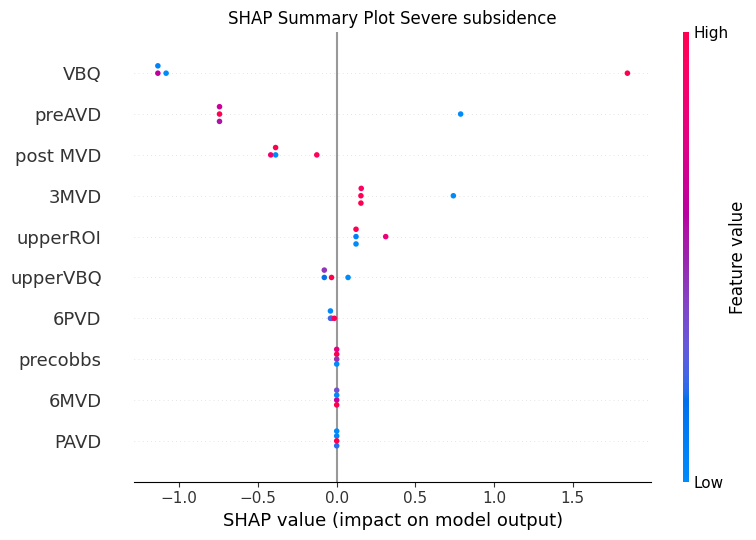

In [20]:
#5. SHAP 분석 (Tree SHAP)
# SHAP Explainer 생성
explainer = shap.Explainer(lgbm_clf)
shap_values = explainer.shap_values(X_test_selected_df) # Use X_test_selected_df for shap_values calculation consistency

# (참고) LightGBM 이진 분류의 경우 shap_values가 리스트[Array(Class0), Array(Class1)] 형태일 수 있음
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 6. SHAP 시각화
plt.figure(figsize=(20, 6))
plt.title("SHAP Summary Plot Severe subsidence")
plt.savefig('figure.png', dpi=300)
shap.summary_plot(shap_values, X_test_selected_df, show=False) # Use X_test_selected_df here as well
plt.tight_layout()
plt.show()

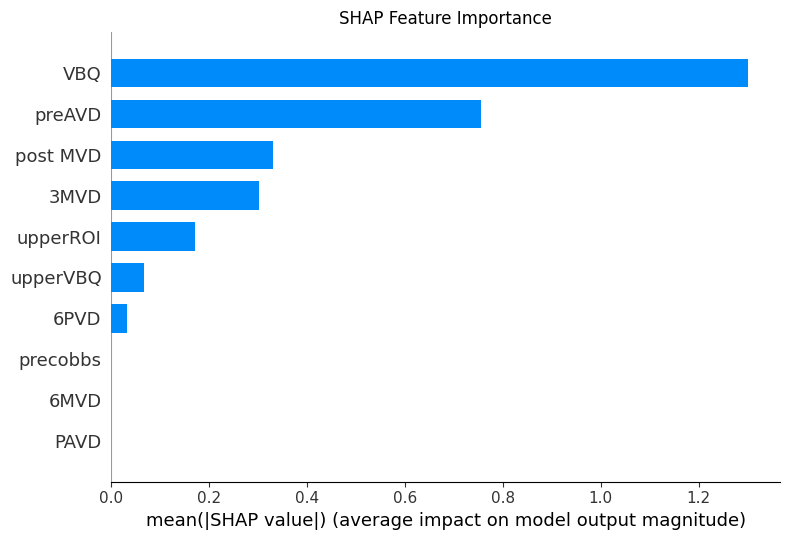

<Figure size 640x480 with 0 Axes>

In [21]:
# 변수 중요도 (Bar Plot)
plt.figure(figsize=(10, 6))
plt.title("SHAP Feature Importance")
shap.summary_plot(shap_values, X_test_selected_df, plot_type="bar", show=True) # Changed X_test to X_test_selected_df
plt.tight_layout()
plt.show()

In [22]:
# Check descriptive statistics of X_train
print("Descriptive statistics of X_train:")
display(X_train.describe())

# Check for columns with zero variance (constant values)
constant_columns = X_train.columns[X_train.nunique() == 1]
if len(constant_columns) > 0:
    print(f"\nColumns with constant values (zero variance): {list(constant_columns)}")
else:
    print("\nNo columns with constant values found in X_train.")


Descriptive statistics of X_train:


,성별,나이,BMI,당뇨,흡연,수술레벨,preAVD,preMVD,prePVD,post AVD,...,PreTIH,PostTIH,FTIH,precobbs,postcobbs,vertebral diameter,trumpet shape drilling,VBQ,upperVBQ,lowerVBQ
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,1.205882,56.029412,24.647059,0.147059,2.029412,2.411765,4.270588,5.682353,2.920588,9.585294,...,35.282353,6.052941,34.721176,6.367647,7.214706,33.306176,0.382353,2.289118,2.189412,2.677353
std,0.410426,9.974164,4.341640,0.359491,0.968763,1.018545,1.456756,1.861975,1.071894,1.906946,...,5.595275,3.440611,4.191251,5.156621,4.499032,3.097301,0.493270,0.526857,0.613494,3.155719
min,1.000000,33.000000,16.400000,0.000000,1.000000,1.000000,1.700000,2.100000,1.200000,4.000000,...,26.810000,0.230000,27.710000,0.100000,0.700000,28.350000,0.000000,1.550000,1.020000,1.250000
25%,1.000000,49.000000,21.400000,0.000000,1.000000,2.000000,3.175000,4.625000,2.225000,8.825000,...,32.387500,3.575000,31.962500,1.950000,4.175000,30.887500,0.000000,1.870000,1.775000,1.760000
50%,1.000000,57.500000,23.850000,0.000000,2.000000,2.500000,4.000000,5.550000,2.750000,9.850000,...,33.710000,6.160000,35.145000,4.900000,6.350000,32.860000,0.000000,2.200000,2.075000,2.215000
75%,1.000000,62.000000,28.100000,0.000000,3.000000,3.000000,5.100000,6.450000,3.550000,10.975000,...,36.350000,7.907500,37.142500,10.225000,8.800000,34.907500,1.000000,2.617500,2.557500,2.545000
max,2.000000,77.000000,35.200000,1.000000,3.000000,4.000000,8.600000,11.200000,4.900000,12.300000,...,54.690000,14.680000,50.140000,17.500000,19.500000,40.150000,1.000000,3.340000,3.670000,20.300000



No columns with constant values found in X_train.


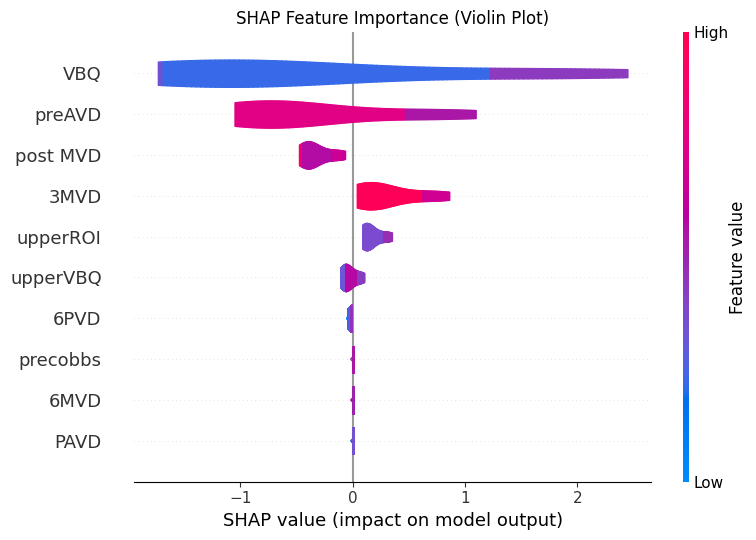

In [23]:
# SHAP 특성 중요도 (Violin Plot)
plt.figure(figsize=(10, 8))
plt.title("SHAP Feature Importance (Violin Plot)")
shap.summary_plot(shap_values, X_test_selected_df, plot_type="violin", show=False) # Changed X_test to X_test_selected_df
plt.tight_layout()
plt.show()

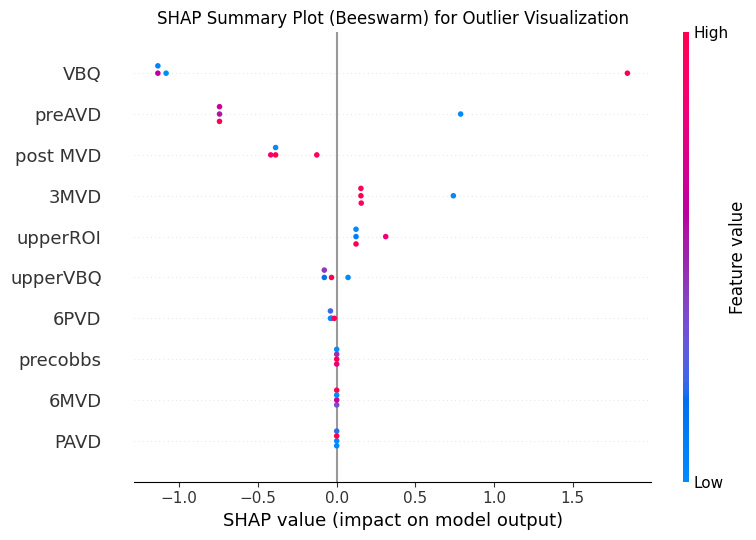

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(20, 10))
plt.title("SHAP Summary Plot (Beeswarm) for Outlier Visualization")
shap.summary_plot(shap_values, X_test_selected_df) # Changed X_test to X_test_selected_df
plt.tight_layout()
plt.show()

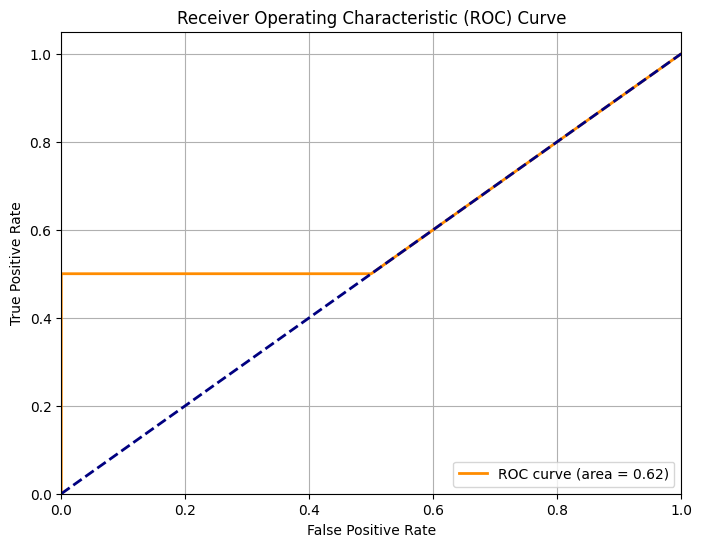

In [25]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()